# LangGraph part 2

In [1]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random

In [2]:
load_dotenv(override=True)

True

### Setup LangSmith
https://langsmith.com

In [3]:
# Use Google Serper for a WebSearch
from langchain_community.utilities import GoogleSerperAPIWrapper
serper = GoogleSerperAPIWrapper()
serper.run("What is the Capital of France")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. Paris is the capital city of France and a cultural and culinary hub. In 2024 it playe

In [4]:
from langchain.tools import Tool

tool_search = Tool(
    name="search",
    func=serper.run,
    description="Useful for when you need mre information from an online search"
)

In [5]:
tool_search.invoke("What is the capital of France?")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. Paris is the capital city of France and a cultural and culinary hub. In 2024 it playe

In [6]:
def push(text: str) -> None:
    """Send a push notification to the user"""
    print(f"Message to push: {text}")
    print(f"Push successful")

In [7]:
tool_push = Tool(
    name="send_push_notification",
    func=push,
    description="Useful for when you want to send a push notification"
)

tool_push.invoke("It's a me, Mario!")

Message to push: It's a me, Mario!
Push successful


## Connect it all together
Now, it'll be a little twist - instead of `BaseModel`, we'll use `TypedDict`.

When implementing tools, there are always two changes to the code:
* Changes to provide the tools to OpenAI in JSON when making the call
* Changes to handle the results back:
    * Look for the model stating that the `finish_reason=="tool_calls"`
    * Retrieve the call
    * Run the function
    * Provide the result

In [8]:
tools = [tool_search, tool_push]

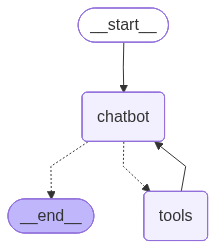

In [9]:
### Define the State
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
### Start the Graph Builder
graph_builder = StateGraph(State)

### Create LLM wrapper
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

### Create a Node
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

### Create Edges
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")

# Any time the tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

### Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [10]:
### Invoke Graph
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()
    

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


# Adding the memory!
Te whole Graph is maintaining the state and appending to the state. But this does not handle the memory.

This is a crucial point in understanding LangGraph.
> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.

One "Super-step" of the graph represents one invocation of passing the messages between agents. In idiomatic LangGraph you call `invoke()` to run your graph for each super-step (for each iteration).

The reducer handles state updates automatically within one super-step, but not between them. That is what **checkpointing** achieves.


In [11]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

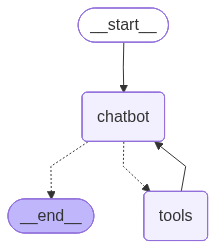

In [12]:
# Steps 1 & 2
graph_builder = StateGraph(State)

# Step 3 
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State): 
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [14]:
# Get current graph state
graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [15]:
# Get state history
list(graph.get_state_history(config))

[]

### LangChain gives the tools to set the state back to a prior point in time, to branch off:
> `config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}`

> `graph.invoke(None, config=config)`

This feature allows to build system that can be recovered and rerun from any prior checkpoint.

### What's more, it can be stored in the SQL.

In [16]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

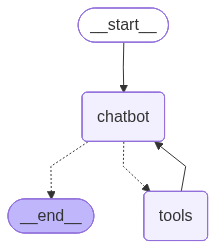

In [17]:
# Steps 1 & 2
graph_builder = StateGraph(State)

# Step 3 
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State): 
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "2"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi there!', additional_kwargs={}, response_metadata={}, id='04b8c461-827b-4389-9767-4e83bcd53aa5'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 91, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_50906f2aac', 'id': 'chatcmpl-CiKvNuZbUuhNa6MAQUkln8SopdlWB', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--314fecd7-6a7d-4f42-9c15-86593d463bd6-0', usage_metadata={'input_tokens': 91, 'output_tokens': 10, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='whats